In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
%matplotlib inline

In [2]:
# Oracle for a given weights matrix
def dijk(w):
    # Dijkstra
    # set initial conditions
    L = int(math.sqrt(len(w))) # number of vertices
    w = w.reshape(L,L)
    unvisited = list(range(L))
    distances = [999999]*L
    distances[0] = 0
    paths = [[0]]*L

    while len(unvisited) > 0:
        i = np.argmin([distances[i] for i in unvisited])
        v = unvisited[i]
        unvisited.pop(i)
        for u in range(L):
            if distances[u] > distances[v] + w[v, u]:
                distances[u] = distances[v] + w[v, u]
                paths[u] = paths[v][:]
                paths[u].append(u)
    
    short = paths[-1]
    # store observed paths
    A = np.arange(L**2).reshape(L,L)
    out = []
    for i in range(len(short)-1):
        out.append(A[short[i], short[i+1]])
        
    A = np.zeros(L**2)
    A[out] = 1
    return(out, A)

In [ ]:
# Wan, Kveton and Ashkan 2015 CombLinTS algorithm
# Should work better than other algorithms when L is very large as doesn't depend on L
# Makes use of Lxd generalization matrix Φ of features for each element of E
# w̄ lies on or close to subspace span of Φ
# define θ∗ = argmin_θ ||w̄ − Φθ||_2
# could think of features as for example knowledge of other activities/events which affects outcome - 
# like characteristics of movies which could predict rating??


# Scenario: User knows Φ matrix of activities/events
# At each stage user samples coefficients θ used to estimate w̄
# and uses this estimate with oracle to determine which move to play
# observes weight for each play and updates parameters of θ sampling accordingly

### Set parameters
L = 16 # 4x4 grid with 16 possible edges
lambda_true = 10 # (used to generate true coefficients of Φ which are then used to calculate w̄ )
sigma_true = 1 # (used when adding noise to true w at each iteration)
d = L
phi = np.random.normal(0, 1, (L,d))
#phi = np.random.uniform(0, 1, L*d).reshape(L,d)
#theta_opt = np.random.multivariate_normal([0]*d, np.diag([lambda_true**2]*d))
w_bar = np.array([0,100,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
#w_bar = np.array([0,10,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
theta_opt = np.linalg.solve(phi,w_bar)

In [132]:
# Wan, Kveton and Ashkan 2015 CombLinTS algorithm
# Should work better than other algorithms when L is very large as doesn't depend on L
# Makes use of Lxd generalization matrix Φ of features for each element of E
# w̄ lies on or close to subspace span of Φ
# define θ∗ = argmin_θ ||w̄ − Φθ||_2
# could think of features as for example knowledge of other activities/events which affects outcome - 
# like characteristics of movies which could predict rating??


# Scenario: User knows Φ matrix of activities/events
# At each stage user samples coefficients θ used to estimate w̄
# and uses this estimate with oracle to determine which move to play
# observes weight for each play and updates parameters of θ sampling accordingly

### Set parameters
#L = 16 # 4x4 grid with 16 possible edges
lambda_true = 10 # (used to generate true coefficients of Φ which are then used to calculate w̄ )
sigma_true = 0.2 # (used when adding noise to true w at each iteration)
d = L
#phi = np.random.normal(0, 1, (L,d))
phi = np.eye(L)
#phi = np.random.uniform(0, 1, L*d).reshape(L,d)
#theta_opt = np.random.multivariate_normal([0]*d, np.diag([lambda_true**2]*d))
#w_bar = path_means1.reshape(L,)
w_bar = path_means2.reshape(L,)
#w_bar = np.array([0,100,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
#w_bar = np.array([0,10,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
theta_opt = np.linalg.solve(phi,w_bar)

In [ ]:
w_bar.reshape(V,V)

In [127]:
theta_opt

array([ 0.        ,  0.25456564,  0.14112207,  0.99936511,  0.00686668,
        0.8184422 ,  0.02048403,  0.64717919,  0.51902825,  1.        ,
        0.09667057,  0.        ,  0.07717914,  0.1837748 ,  0.90331999,
        0.1418605 ,  0.70887373,  0.92188849,  0.58962445,  0.32713378,
        0.5011041 ,  0.61231892,  0.        ,  0.73163863,  0.53341811,
        0.96898879,  0.51764703,  0.99310804,  0.53331763,  0.91798318,
        0.39278907,  0.76899963,  0.15623715,  0.        ,  0.65694365,
        0.81592824,  0.35509383,  0.84659696,  0.56867437,  0.22366422,
        0.50397305,  0.41014485,  0.13792159,  0.62894264,  0.        ,
        0.64678616,  0.25178649,  0.88117397,  0.91158486,  0.8273427 ,
        0.22795725,  0.89402077,  0.05742877,  0.0564621 ,  0.13415585,
        0.        ,  0.97954148,  0.05675568,  0.88198607,  0.67974769,
        0.95403093,  0.44826824,  0.25933291,  0.21646015,  0.78865601,
        0.42698901,  0.        ,  0.14336821,  0.09217299,  0.23

In [ ]:
phi

In [ ]:
a=np.dot(phi,theta_opt)

In [ ]:
%time b = np.maximum(a,0)

In [ ]:
b

In [ ]:
%time a[a < 0] = 0

In [ ]:
a

In [ ]:
dijk(a)

In [ ]:
dijk(np.dot(phi,theta_opt))

In [ ]:
dijk(w_bar)

In [133]:
# Shortest path case for toy example
iters = 1000
w_est = np.zeros((L, iters))
w_actual = np.zeros((L, iters))
A = np.zeros((L, iters))
theta = np.zeros((d, iters+1))
### INIT
t=0
lamb = 5
sigma = 75
cov_mat = [np.diag([lamb**2]*d)]*(iters+1)
theta[:,t] = [0]*d

In [134]:
### iterate over number of iterations
for t in tqdm(range(iters)):
    # draw sample theta and use to estimate w
    theta_sample = np.random.multivariate_normal(theta[:,t], cov_mat[t])
    w_est[:,t] = np.maximum(np.dot(phi, theta_sample),0)
    # Solve oracle for w_est and get A_t - can be any number of elements
    (edges, A[:,t]) = dijk(w_est[:,t])
    #A.append(dijk(w_est[:,t]))

    # calcualate actual w based on theta_opt plus some noise
    w_actual_noise = np.random.normal(0, sigma_true**2, L)
    w_actual[:,t] = np.maximum(0,w_bar + w_actual_noise)
    
    # update covariance matrix and theta
    # init
    theta[:,(t+1)] = theta[:,t]
    cov_mat[t+1] = cov_mat[t]
    for k in edges:
        # update theta
        theta[:,(t+1)]=(np.dot(((np.eye(d))-((np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:])),(phi[k,:]))) / 
                              (np.dot(np.dot(phi[k,:],cov_mat[t+1]),np.transpose(phi[k,:])) + sigma**2))) , 
                (theta[:,(t+1)]))) + (
        np.dot(((np.dot(cov_mat[t+1],np.transpose(phi[k,:])))/(np.dot(np.dot(phi[k,:],cov_mat[t+1]),np.transpose(phi[k,:])) + sigma**2)),w_actual[k,t]))
        
        # update covariance matrix
        cov_mat[t+1] = (cov_mat[t+1] -
         ((np.dot(np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:])),phi[k,:]),cov_mat[t+1]))/(np.dot(np.dot(phi[k,:],cov_mat[t+1]),np.transpose(phi[k,:])) + sigma**2)))

100%|██████████| 1000/1000 [00:03<00:00, 272.24it/s]


In [68]:
theta[:,1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [69]:
t=1
theta_sample = np.random.multivariate_normal(theta[:,t], cov_mat[t])

In [70]:
theta_sample

array([  1.11902872e+00,   6.36829429e-01,  -5.67913914e-01,
         1.09059017e+00,   7.68921175e-01,  -3.31295579e-01,
         1.22426487e+00,   5.40592013e-01,   7.31854809e-02,
         1.09772641e+00,   1.95866964e+00,   6.80096567e-02,
         1.13674313e+00,   3.57976937e-01,  -1.01472214e+00,
         6.44217441e-01,   1.12991994e+00,  -8.74879178e-01,
        -1.24362400e+00,   1.94008575e+00,  -6.31525672e-01,
         4.82782061e-01,   8.08457612e-01,   1.16575215e+00,
        -3.36481606e-01,  -5.17908961e-01,  -1.10412612e+00,
         3.93918810e-01,  -6.43191798e-01,   4.14331828e-01,
         3.06770351e-02,   8.93162827e-01,  -5.83731913e-01,
         8.22466515e-01,   9.72368439e-01,   7.49039498e-01,
         3.25572763e-01,  -2.07621247e+00,  -6.65974967e-01,
        -7.42988191e-01,  -3.44708615e-01,  -6.86479778e-03,
        -1.12097186e-03,   1.88820005e+00,   2.14039360e-01,
        -4.17323590e-01,  -1.27941873e+00,  -7.64940238e-01,
         7.87535349e-01,

In [71]:
theta[:,2]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [72]:
w_est[:,t] = np.maximum(np.dot(phi, theta_sample),0)
# Solve oracle for w_est and get A_t - can be any number of elements
(edges, A[:,t]) = dijk(w_est[:,t])
#A.append(dijk(w_est[:,t]))

In [73]:
edges

[5, 59]

In [74]:
# calcualate actual w based on theta_opt plus some noise
w_actual_noise = np.random.normal(0, sigma_true**2, L)
w_actual[:,t] = np.maximum(0,w_bar + w_actual_noise)

# update covariance matrix and theta
# init
theta[:,(t+1)] = theta[:,t]
cov_mat[t+1] = cov_mat[t]
for k in edges:
    # update theta
    theta[:,(t+1)]=(np.dot(((np.eye(d))-((np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:])),(phi[k,:]))) / 
                          (np.dot(np.dot(phi[k,:],cov_mat[t+1]),np.transpose(phi[k,:])) + sigma**2))) , 
            (theta[:,(t+1)]))) + (
    np.dot(((np.dot(cov_mat[t+1],np.transpose(phi[k,:])))/(np.dot(np.dot(phi[k,:],cov_mat[t+1]),np.transpose(phi[k,:])) + sigma**2)),w_actual[k,t]))

    # update covariance matrix
    cov_mat[t+1] = (cov_mat[t+1] -
     ((np.dot(np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:])),phi[k,:]),cov_mat[t+1]))/(np.dot(np.dot(phi[k,:],cov_mat[t+1]),np.transpose(phi[k,:])) + sigma**2)))

In [75]:
theta[:,2]

array([-0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
        0.32827785, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232,  0.06211314,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16332232,
       -0.16332232, -0.16332232, -0.16332232, -0.16332232, -0.16

In [80]:
theta_opt

array([ 0.  ,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
        0.85,  0.05,  0.  ,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,
        0.65,  0.75,  0.15,  0.05,  0.  ,  0.05,  0.15,  0.25,  0.35,
        0.45,  0.55,  0.65,  0.25,  0.15,  0.05,  0.  ,  0.05,  0.15,
        0.25,  0.35,  0.45,  0.55,  0.35,  0.25,  0.15,  0.05,  0.  ,
        0.05,  0.15,  0.25,  0.35,  0.45,  0.45,  0.35,  0.25,  0.15,
        0.05,  0.  ,  0.05,  0.15,  0.25,  0.35,  0.55,  0.45,  0.35,
        0.25,  0.15,  0.05,  0.  ,  0.05,  0.15,  0.25,  0.65,  0.55,
        0.45,  0.35,  0.25,  0.15,  0.05,  0.  ,  0.05,  0.15,  0.75,
        0.65,  0.55,  0.45,  0.35,  0.25,  0.15,  0.05,  0.  ,  0.05,
        0.85,  0.75,  0.65,  0.55,  0.45,  0.35,  0.25,  0.15,  0.05,  0.  ])

In [81]:
%time a = theta[:,-1]

CPU times: user 3 µs, sys: 5 µs, total: 8 µs
Wall time: 16 µs


In [82]:
np.dot(phi,a)

array([ 4008594.48428043,  4008594.48428043,  4008597.19388379,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008596.07381205,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428043,  4008594.48428043,
        4008594.48428043,  4008594.48428

In [ ]:
dijk(np.dot(phi,a))

In [ ]:
dijk(np.dot(phi,theta_opt))

In [ ]:
dijk(path_means1.reshape(L,))

In [ ]:
np.append(A,np.dot(phi,a))

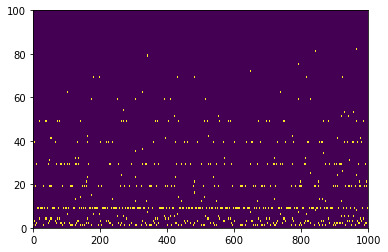

In [135]:
plt.pcolormesh(A)

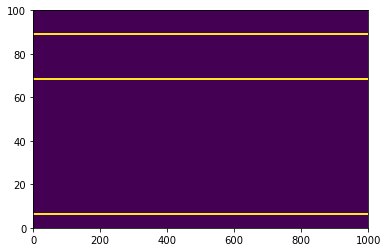

In [131]:
plt.pcolormesh(np.repeat(dijk(path_means2.reshape(L,))[1],iters).reshape(L,iters))

In [ ]:
plt.pcolormesh(w_est)

In [ ]:
path_means1

In [56]:
V = 10
L = V*V
diag_zero = np.ones(L).reshape(V, V) - np.diag(np.ones(V))

path_means1 = np.zeros(L).reshape(V, V)
for i in range(V):
    for j in range(V):
        path_means1[i,j] = abs(i - j)/V - 1/(V*2)
path_means1 = abs(path_means1 * diag_zero)

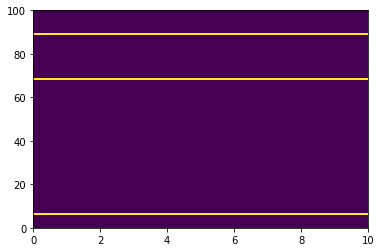

In [125]:
plt.pcolormesh(np.repeat(dijk(path_means2.reshape(L,))[1],10).reshape(L,10))

In [34]:
path_means1[0,-1] = 200

In [58]:
path_means1

array([[ 0.  ,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
         0.85],
       [ 0.05,  0.  ,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,
         0.75],
       [ 0.15,  0.05,  0.  ,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,
         0.65],
       [ 0.25,  0.15,  0.05,  0.  ,  0.05,  0.15,  0.25,  0.35,  0.45,
         0.55],
       [ 0.35,  0.25,  0.15,  0.05,  0.  ,  0.05,  0.15,  0.25,  0.35,
         0.45],
       [ 0.45,  0.35,  0.25,  0.15,  0.05,  0.  ,  0.05,  0.15,  0.25,
         0.35],
       [ 0.55,  0.45,  0.35,  0.25,  0.15,  0.05,  0.  ,  0.05,  0.15,
         0.25],
       [ 0.65,  0.55,  0.45,  0.35,  0.25,  0.15,  0.05,  0.  ,  0.05,
         0.15],
       [ 0.75,  0.65,  0.55,  0.45,  0.35,  0.25,  0.15,  0.05,  0.  ,
         0.05],
       [ 0.85,  0.75,  0.65,  0.55,  0.45,  0.35,  0.25,  0.15,  0.05,  0.  ]])

In [124]:
diag_zero = np.ones(L).reshape(V, V) - np.diag(np.ones(V))
path_means2 = np.random.uniform(0, 1, L).reshape(V, V) * diag_zero
path_means2[0,-1] = 1 # to try to make sure best path isn't to go straight to the end!